In [1]:
import torch
import sys
import torch.onnx
import torch.utils
import torch.utils.data
import torch.nn.functional as F
import torch.nn as nn
from model import ResNet

device = torch.device("cuda:0")

columns = 3
rows = 3
channels = 16
layers = 5
epochs = 100
training_batch_size = 64
inference_batch_size = 256
kl_loss_scale = 0.1

data_folder = "../data"
models_folder = "../models"
generation = 1

class Snapshots(torch.utils.data.Dataset):
    def __init__(self, file_name):
        self.data = [[], [], [], []]
        i = 0
        with open(file_name) as f:
            for line in f.readlines():
                if line.strip() == "":
                    i = 0
                    continue

                t = torch.tensor([float(x) for x in line.split(", ")])

                if i == 0:
                    t = t.view(7, columns, rows)
                self.data[i].append(t)
                i += 1

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, index):
        return [self.data[x][index] for x in range(4)]

In [2]:
def loss_fn(wp_out, sp_out, vs_out, wp_label, sp_label, vs_label):
    kl_div = nn.KLDivLoss(reduction='sum')
    mse = nn.MSELoss(reduction='sum')
    
    # Concatenate the outputs to form the complete action distribution
    actions_out = torch.cat([wp_out, sp_out], dim=1)
    # Apply log_softmax to convert to log probabilities
    log_probs = F.log_softmax(actions_out, dim=1)
    
    # Concatenate the labels to form the complete target distribution
    actions_label = torch.cat([wp_label, sp_label], dim=1)
    
    # Compute the KL divergence loss
    kl_loss = kl_loss_scale * kl_div(log_probs, actions_label)
    
    # Compute the MSE loss for the scalar output
    mse_loss = mse(vs_out, vs_label)

    return (kl_loss, mse_loss)


def save_model(model, folder):
    torch.save(model, f"{folder}/model_{generation}.pt")
    input_names = ["States"]
    output_names = ["WallPriors", "StepPriors", "Values"]
    dummy_input = torch.randn(inference_batch_size, 7, columns, rows).to(device)
    torch.onnx.export(
        model,
        dummy_input,
        f"{folder}/model_{generation}.onnx",
        input_names=input_names,
        output_names=output_names,
    )

In [3]:
model = torch.load(f"{models_folder}/model_{generation - 1}.pt").to(device)

In [4]:
training_window = range((generation - 1) // 2, generation)
snapshots = torch.utils.data.ConcatDataset(
    [Snapshots(f"{data_folder}/snapshots_{i}.csv") for i in training_window]
)
training_data, eval_data = torch.utils.data.random_split(snapshots, [0.8, 0.2])
training_loader = torch.utils.data.DataLoader(
    training_data,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
eval_loader = torch.utils.data.DataLoader(
    eval_data,
    batch_size=training_batch_size,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.02)

In [5]:
import matplotlib.pyplot as plt

def plot_tensor(mat, cmap='viridis'):
    """
    Plots a 2D PyTorch tensor as an n x n grid of squares with colors representing the tensor values.

    Parameters:
    - mat: 2D PyTorch tensor of floats.
    - cmap: Colormap for visualizing the values in the tensor.
    """
    # Ensure mat is a 2D tensor
    if mat.dim() != 2:
        raise ValueError("Input tensor must be 2D")

    # Convert the tensor to a NumPy array
    matrix = mat.numpy()

    # Plotting the matrix
    plt.figure(figsize=(6,6))  # Adjust the figure size as needed
    plt.imshow(matrix, cmap=cmap, interpolation='nearest')  # Use specified colormap
    plt.colorbar()  # Show color scale
    plt.xticks(range(matrix.shape[0]))  # Adjust ticks based on tensor size
    plt.yticks(range(matrix.shape[1]))
    plt.grid(False)  # Turn off the grid
    plt.show()

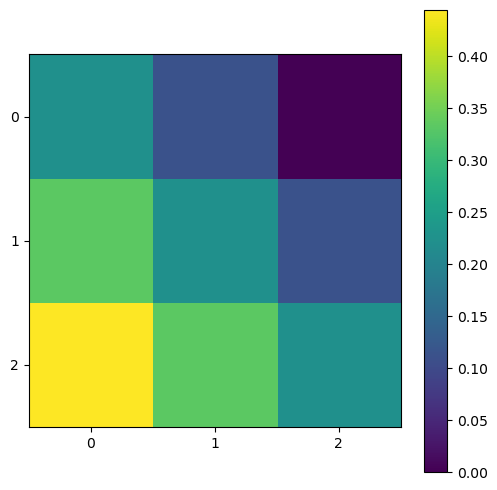

In [6]:
plot_tensor(snapshots[2][0][0])

In [7]:
snapshots[0]

[tensor([[[0.0000, 0.1111, 0.2222],
          [0.1111, 0.2222, 0.3333],
          [0.2222, 0.3333, 0.4444]],
 
         [[0.4444, 0.3333, 0.2222],
          [0.3333, 0.2222, 0.1111],
          [0.2222, 0.1111, 0.0000]],
 
         [[0.2222, 0.1111, 0.0000],
          [0.3333, 0.2222, 0.1111],
          [0.4444, 0.3333, 0.2222]],
 
         [[0.2222, 0.3333, 0.4444],
          [0.1111, 0.2222, 0.3333],
          [0.0000, 0.1111, 0.2222]],
 
         [[0.0000, 0.0000, 1.0000],
          [0.0000, 0.0000, 1.0000],
          [0.0000, 0.0000, 1.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000]],
 
         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]),
 tensor([0.0200, 0.0240, 0.0000, 0.0240, 0.0240, 0.0000, 0.0440, 0.0240, 0.0000,
         0.0200, 0.0240, 0.0240, 0.0240, 0.0740, 0.0260, 0.0000, 0.0000, 0.0000]),
 tensor([0.2000, 0.4480, 0.0000, 0.0000]),
 tensor([1.])]

In [8]:


try:
    for epoch in range(1000):
        total_kl_loss = 0
        total_mse_loss = 0
        for states, wall_priors, step_priors, values in training_loader:
            states = states.to(device)
            wall_priors = wall_priors.to(device)
            step_priors = step_priors.to(device)
            values = values.to(device)
    
            optimizer.zero_grad()
            wp, sp, vs = model.forward(states)
            kl_loss, mse_loss = loss_fn(wp, sp, vs, wall_priors, step_priors, values)
            total_kl_loss += float(kl_loss)
            total_mse_loss += float(mse_loss)

            loss = kl_loss + mse_loss
            loss.backward()
            optimizer.step()
            del loss
        print(
            f"Training loss in epoch {epoch} of generation {generation}: {total_kl_loss / len(training_data)} + {total_mse_loss / len(training_data)} = {(total_kl_loss + total_mse_loss) / len(training_data)}."
        )
        
        model.train(False)
        total_kl_loss = 0
        total_mse_loss = 0
        for states, wall_priors, step_priors, values in eval_loader:
            states = states.to(device)
            wall_priors = wall_priors.to(device)
            step_priors = step_priors.to(device)
            values = values.to(device)
            wp, sp, vs = model.forward(states)
            kl_loss, mse_loss = loss_fn(wp, sp, vs, wall_priors, step_priors, values)
            total_kl_loss += float(kl_loss)
            total_mse_loss += float(mse_loss)
        print(
            f"Evaluation loss in epoch {epoch} of generation {generation}: {total_kl_loss / len(eval_data)} + {total_mse_loss / len(eval_data)} = {(total_kl_loss + total_mse_loss) / len(eval_data)}."
        )
except KeyboardInterrupt:
    print("Trainig was interrupted.")

Training loss in epoch 0 of generation 1: 0.12040106638762495 + 0.13458752629413784 = 0.25498859268176277.
Evaluation loss in epoch 0 of generation 1: 0.11795403501291009 + 0.1170065313120169 = 0.234960566324927.
Training loss in epoch 1 of generation 1: 0.12840064112462793 + 1.0217612264748044 = 1.1501618675994325.
Evaluation loss in epoch 1 of generation 1: 0.13682486475939862 + 1.8491846701432 = 1.9860095349025986.
Training loss in epoch 2 of generation 1: 0.1364523731744827 + 1.8756484405967824 = 2.0121008137712653.
Evaluation loss in epoch 2 of generation 1: 0.13682486475939862 + 1.815412631404685 = 1.9522374961640836.
Training loss in epoch 3 of generation 1: 0.1364523734001878 + 1.8491526475883047 = 1.9856050209884926.
Evaluation loss in epoch 3 of generation 1: 0.13682486475939862 + 1.815412631404685 = 1.9522374961640836.
Training loss in epoch 4 of generation 1: 0.1364523731609157 + 1.8491526475883047 = 1.9856050207492204.
Evaluation loss in epoch 4 of generation 1: 0.13682486

In [9]:
initial_state = torch.unsqueeze(snapshots[0][0], 0).to(device)

In [10]:
model.forward(initial_state)

(tensor([[1.3669e-04, 6.8333e-12, 9.3426e-12, 2.3319e-12, 3.1439e-12, 9.1561e-12,
          2.7555e-11, 3.3933e-07, 8.5234e-12, 1.3690e-06, 8.1702e-10, 2.3860e-12,
          3.5768e-10, 1.6445e-19, 7.3545e-11, 9.4305e-12, 9.1262e-12, 9.4213e-12]],
        device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([[9.9592e-01, 9.9970e-01, 1.9444e-09, 3.9429e-06]], device='cuda:0',
        grad_fn=<SigmoidBackward0>),
 tensor([[0.9198]], device='cuda:0', grad_fn=<TanhBackward0>))

In [16]:
save_model(model, models_folder)